Variable: Monthly Mean Total Sunspot Number
Best Lag: 6
Best Polynomial Degree: 2
Best Metric (RMSE): 22.50808575629147

Variable: Uncertainty
Best Lag: 12
Best Polynomial Degree: 1
Best Metric (RMSE): 1.4833130138519453

Variable: Observations
Best Lag: 11
Best Polynomial Degree: 1
Best Metric (RMSE): 69.0905202977891



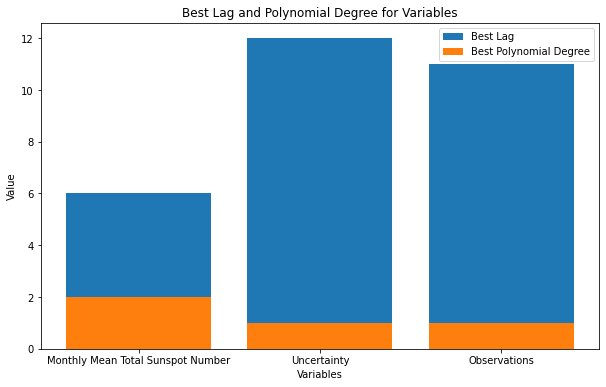

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations', 'Definitive/Provisional']

# Select the variables to investigate
variables_to_investigate = ['Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations']

# Define the lag range and polynomial degrees to explore
lag_range = range(1, 13)
poly_degrees = range(1, 6)

# Initialize lists to store the best lag and polynomial degree for each variable
best_lags = []
best_poly_degrees = []

# Iterate over each variable
for variable in variables_to_investigate:
    target = data[variable].values.reshape(-1, 1)

    # Normalize the target variable
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaled = scaler.fit_transform(target)

    # Initialize variables to store the best evaluation metric and corresponding lag and polynomial degree
    best_metric = np.inf
    best_lag = None
    best_poly_degree = None

    # Perform lag selection and polynomial degree selection
    for lag in lag_range:
        # Create lagged version of the target variable
        lagged_target = pd.DataFrame(target_scaled, columns=['Target'])
        for i in range(1, lag + 1):
            lagged_target[f'Lag_{i}'] = lagged_target['Target'].shift(i)
        lagged_target.dropna(inplace=True)

        features = lagged_target.drop('Target', axis=1).values
        target = lagged_target['Target'].values

        # Iterate over polynomial degrees
        for poly_degree in poly_degrees:
            # Create polynomial features
            poly_features = PolynomialFeatures(degree=poly_degree)
            features_poly = poly_features.fit_transform(features)

            # Split the data into training and testing sets
            train_size = int(0.8 * len(features_poly))
            train_features = features_poly[:train_size]
            train_target = target[:train_size]
            test_features = features_poly[train_size:]
            test_target = target[train_size:]

            # Train the linear regression model
            model = LinearRegression()
            model.fit(train_features, train_target)

            # Make predictions
            train_predictions = model.predict(train_features)
            test_predictions = model.predict(test_features)

            # Invert the scaling
            train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
            train_target = scaler.inverse_transform(train_target.reshape(-1, 1))
            test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
            test_target = scaler.inverse_transform(test_target.reshape(-1, 1))

            # Calculate RMSE
            metric = np.sqrt(mean_squared_error(test_target, test_predictions))

            # Update the best metric and corresponding lag and polynomial degree if necessary
            if metric < best_metric:
                best_metric = metric
                best_lag = lag
                best_poly_degree = poly_degree

    # Append the best lag and polynomial degree for the current variable
    best_lags.append(best_lag)
    best_poly_degrees.append(best_poly_degree)

    # Print the results for the current variable
    print(f"Variable: {variable}")
    print(f"Best Lag: {best_lag}")
    print(f"Best Polynomial Degree: {best_poly_degree}")
    print(f"Best Metric (RMSE): {best_metric}")
    print()

# Plot the best lag and polynomial degree for each variable
plt.figure(figsize=(10, 6))
plt.bar(range(len(variables_to_investigate)), best_lags, label='Best Lag')
plt.bar(range(len(variables_to_investigate)), best_poly_degrees, label='Best Polynomial Degree')
plt.xticks(range(len(variables_to_investigate)), variables_to_investigate)
plt.title('Best Lag and Polynomial Degree for Variables')
plt.xlabel('Variables')
plt.ylabel('Value')
plt.legend()
plt.show()
